In [3]:
# proposition theme
!pip install geopy
!conda install -c conda-forge folium=0.5.0 --yes 

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
%matplotlib inline 
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


# Introduction

## Business Problem

Client: I want to know the best place to visit in Washington DC according to their ratings and feasibility, how will you suggest to proceed

Me: As per client's requirement and time constraint i searched the web and took 4 potential places to determine the best according to locality and feasibility

In [1]:
data = [['Lincoln Memorial', 38.8893, -77.0502], ['National Air and Sapce Museum', 38.8882, -77.0199], ['National Mall', 38.8896, -77.0230], ['Vietnam Veterans Memorial', 38.8913, -77.0477]] 

In [4]:
wash_data= pd.DataFrame(data, columns = ['Lieux', 'Latitude','Longitude']) 

In [67]:
wash_data

,Lieux,Latitude,Longitude,Cluster Labels
0,Lincoln Memorial,38.8893,-77.0502,0
1,National Air and Sapce Museum,38.8882,-77.0199,3
2,National Mall,38.8896,-77.0230,1
3,Vietnam Veterans Memorial,38.8913,-77.0477,2


## Data

### Step 1 - Location Placement on the map of Paris

In [6]:
# Localise Lieux on the map Paris
address = 'Washington DC, US'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Washington Dc are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Washington Dc are 38.8948932, -77.0365529.


In [7]:
# create map of wash using latitude and longitude values
map_wash = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, label in zip(wash_data['Latitude'], wash_data['Longitude'], wash_data['Lieux']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_wash)  
    
map_wash

In [63]:
CLIENT_ID = '1EH01SK1KF05C4GKBFLMWEPRE2EWBS10TKXQE4X3DQUELTFA' # your Foursquare ID
CLIENT_SECRET = 'VJFZ4UL3PP0ZHZS3G4IFIVTBSSUSM5QIFLTMLMPJYAJEMRWG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1EH01SK1KF05C4GKBFLMWEPRE2EWBS10TKXQE4X3DQUELTFA
CLIENT_SECRET:VJFZ4UL3PP0ZHZS3G4IFIVTBSSUSM5QIFLTMLMPJYAJEMRWG


# Methodology Section

## Explore the city

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,            
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Lieux', 
                  'Lieux Latitude', 
                  'Lieux Longitude', 
                  'Venue',
                  'Venue id',                
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category'
                             
                   ]
    
    return(nearby_venues)

## Step 3 - Rating of Venue's of Washington DC

In [12]:
venue_id ={
    'Lincoln Memorial': '4a4fbaecf964a520a0af1fe3',
    'National Air and Sapce Museum': '4a0cfc37f964a52074751fe3',
    'National Mall': '49c2fff9f964a5204d561fe3',
    'Vietnam Veterans Memorial': '4a500fe1f964a520f2af1fe3'
}

for key,value in venue_id.items():
    
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(value, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    try:
        print('Venue :', key)
        print('Rating : ', result['response']['venue']['rating'])
        print('Total Tips : ', result['response']['venue']['tips']['count'])
        print('Nb Likes : ', result['response']['venue']['tips']['groups'][0]['items'][0]['likes']['count'])
        print('Nb Likes / Total Tips', (result['response']['venue']['tips']['groups'][0]['items'][0]['likes']['count'])/ (result['response']['venue']['tips']['count']) *100 )
        
        print()

    except:
        print('This venue has not been rated yet.')



Venue : Lincoln Memorial
Rating :  9.6
Total Tips :  461
Nb Likes :  139
Nb Likes / Total Tips 30.151843817787416

Venue : National Air and Sapce Museum
Rating :  9.2
Total Tips :  647
Nb Likes :  136
Nb Likes / Total Tips 21.020092735703248

Venue : National Mall
Rating :  9.5
Total Tips :  267
Nb Likes :  44
Nb Likes / Total Tips 16.479400749063668

Venue : Vietnam Veterans Memorial
Rating :  9.3
Total Tips :  91
Nb Likes :  79
Nb Likes / Total Tips 86.81318681318682



In [13]:
wash_data_venues = getNearbyVenues(names=wash_data['Lieux'],
                                   latitudes=wash_data['Latitude'],
                                   longitudes=wash_data['Longitude']
                                  )
#print(wash_data_venues.shape)
wash_data_venues

Lincoln Memorial
National Air and Sapce Museum
National Mall
Vietnam Veterans Memorial


,Lieux,Lieux Latitude,Lieux Longitude,Venue,Venue id,Venue Latitude,Venue Longitude,Venue Category
0,Lincoln Memorial,38.8893,-77.0502,Lincoln Memorial,4a4fbaecf964a520a0af1fe3,38.889267,-77.050166,Monument / Landmark
1,Lincoln Memorial,38.8893,-77.0502,Vietnam Veterans Memorial - Three Servicemen S...,504ca3e0e889b404915747e2,38.890640,-77.048257,Outdoor Sculpture
2,Lincoln Memorial,38.8893,-77.0502,Korean War Veterans Memorial,4a491e86f964a520ffaa1fe3,38.887790,-77.047472,Monument / Landmark
3,Lincoln Memorial,38.8893,-77.0502,Vietnam Veterans Memorial,4a500fe1f964a520f2af1fe3,38.891262,-77.047707,Monument / Landmark
4,Lincoln Memorial,38.8893,-77.0502,Memorial Bridge Equestrian Statues,4c0c0e8399459521159974dd,38.888547,-77.052075,Sculpture Garden
5,Lincoln Memorial,38.8893,-77.0502,Albert Einstein Memorial,4a4fbc96f964a520a5af1fe3,38.892334,-77.048351,Outdoor Sculpture
6,Lincoln Memorial,38.8893,-77.0502,Lincoln Memorial Reflecting Pool,4b65f636f964a5203e0b2be3,38.889491,-77.045649,Monument / Landmark
7,Lincoln Memorial,38.8893,-77.0502,West Potomac Park,4bc0aeceabf49521f8a0bf93,38.886223,-77.047334,Park
8,Lincoln Memorial,38.8893,-77.0502,Lincoln Memorial Sand Volleyball Courts,4ba3e8d3f964a520b66c38e3,38.891183,-77.053744,Volleyball Court
9,Lincoln Memorial,38.8893,-77.0502,Gifts & Cafe,4dded899b0fbc2c4ef0cca12,38.890800,-77.049302,Gift Shop


In [14]:
wash_data_venues.groupby('Lieux').count()

,Lieux Latitude,Lieux Longitude,Venue,Venue id,Venue Latitude,Venue Longitude,Venue Category
Lieux,,,,,,,
Lincoln Memorial,13,13,13,13,13,13,13
National Air and Sapce Museum,47,47,47,47,47,47,47
National Mall,62,62,62,62,62,62,62
Vietnam Veterans Memorial,18,18,18,18,18,18,18


## Step 5 - Histogram

In [16]:
df_view = wash_data_venues.groupby('Lieux').count()
df_toto = df_view['Venue Category']
df_toto

Lieux
Lincoln Memorial                 13
National Air and Sapce Museum    47
National Mall                    62
Vietnam Veterans Memorial        18
Name: Venue Category, dtype: int64

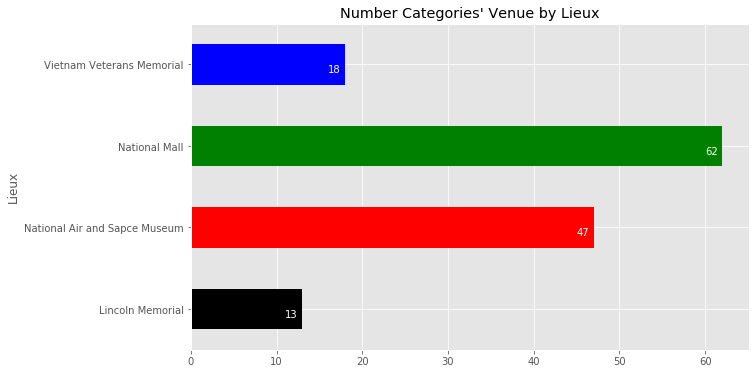

In [17]:
df_toto.plot(kind='barh', figsize=(10,6),color=['black', 'red', 'green', 'blue'])

#plt.xlabel('name') # add to x-label to the plot
#plt.ylabel('Number de categories') # add y-label to the plot
plt.title('Number Categories\' Venue by Lieux') # add title to the plot

for index, value in enumerate(df_toto): 
    label = format(int(value), ',') 
    plt.annotate(label, xy=(value - 2, index - 0.10), color='white')
    
plt.show()

## Step 6 - Analyse for each Categories


In [18]:
wash_onehot = pd.get_dummies(wash_data_venues[['Venue Category']], prefix="", prefix_sep="")

# add Lieux column back to dataframe
wash_onehot['Lieux'] = wash_data_venues['Lieux'] 

# move lieux column to the first column
fixed_columns = [wash_onehot.columns[-1]] + list(wash_onehot.columns[:-1])
wash_onehot = wash_onehot[fixed_columns]

wash_onehot.head()

,Lieux,American Restaurant,Art Gallery,Art Museum,Bakery,Bank,Baseball Field,Building,Café,Coffee Shop,Deli / Bodega,Donut Shop,Exhibit,Food Court,Food Truck,Fountain,French Restaurant,Garden,Gift Shop,Government Building,History Museum,Hotel,Ice Cream Shop,Lake,Monument / Landmark,Movie Theater,Museum,Outdoor Sculpture,Outdoors & Recreation,Park,Performing Arts Venue,Pizza Place,Planetarium,Plaza,Public Art,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Skating Rink,Snack Place,Soccer Field,Theme Park Ride / Attraction,Train Station,Volleyball Court
0,Lincoln Memorial,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Lincoln Memorial,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Lincoln Memorial,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Lincoln Memorial,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Lincoln Memorial,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [19]:
wash_grouped = wash_onehot.groupby('Lieux').mean().reset_index()
wash_grouped

,Lieux,American Restaurant,Art Gallery,Art Museum,Bakery,Bank,Baseball Field,Building,Café,Coffee Shop,Deli / Bodega,Donut Shop,Exhibit,Food Court,Food Truck,Fountain,French Restaurant,Garden,Gift Shop,Government Building,History Museum,Hotel,Ice Cream Shop,Lake,Monument / Landmark,Movie Theater,Museum,Outdoor Sculpture,Outdoors & Recreation,Park,Performing Arts Venue,Pizza Place,Planetarium,Plaza,Public Art,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Skating Rink,Snack Place,Soccer Field,Theme Park Ride / Attraction,Train Station,Volleyball Court
0,Lincoln Memorial,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.307692,0.000000,0.000000,0.153846,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.153846,0.000000,0.076923,0.000000,0.000000,0.000000,0.076923
1,National Air and Sapce Museum,0.000000,0.021277,0.106383,0.000000,0.000000,0.000000,0.021277,0.021277,0.021277,0.021277,0.000000,0.085106,0.021277,0.191489,0.021277,0.000000,0.021277,0.021277,0.021277,0.021277,0.021277,0.000000,0.000000,0.000000,0.021277,0.021277,0.000000,0.000000,0.000000,0.021277,0.021277,0.021277,0.042553,0.021277,0.021277,0.021277,0.085106,0.021277,0.021277,0.000000,0.000000,0.021277,0.000000,0.000000
2,National Mall,0.016129,0.016129,0.096774,0.016129,0.016129,0.000000,0.000000,0.032258,0.064516,0.000000,0.000000,0.080645,0.000000,0.145161,0.000000,0.016129,0.016129,0.016129,0.000000,0.048387,0.000000,0.016129,0.000000,0.016129,0.016129,0.032258,0.000000,0.000000,0.000000,0.000000,0.000000,0.016129,0.048387,0.000000,0.000000,0.016129,0.177419,0.032258,0.016129,0.016129,0.000000,0.000000,0.016129,0.000000
3,Vietnam Veterans Memorial,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.111111,0.000000,0.000000,0.055556,0.055556,0.000000,0.000000,0.000000,0.000000,0.055556,0.222222,0.000000,0.000000,0.111111,0.055556,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.055556,0.000000,0.055556,0.000000,0.055556,0.055556,0.000000,0.000000,0.000000


## Most Common Venues (Top 10)

In [20]:
num_top_venues = 20

for hood in wash_grouped['Lieux']:
    print("----"+hood+"----")
    temp = wash_grouped[wash_grouped['Lieux'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Lincoln Memorial----
                    venue  freq
0     Monument / Landmark  0.31
1       Outdoor Sculpture  0.15
2        Sculpture Garden  0.15
3        Volleyball Court  0.08
4          Baseball Field  0.08
5             Snack Place  0.08
6                    Park  0.08
7               Gift Shop  0.08
8             Planetarium  0.00
9                  Museum  0.00
10  Outdoors & Recreation  0.00
11  Performing Arts Venue  0.00
12            Pizza Place  0.00
13         Sandwich Place  0.00
14                  Plaza  0.00
15             Public Art  0.00
16         Scenic Lookout  0.00
17         Science Museum  0.00
18           Skating Rink  0.00
19           Soccer Field  0.00


----National Air and Sapce Museum----
                    venue  freq
0              Food Truck  0.19
1              Art Museum  0.11
2          Science Museum  0.09
3                 Exhibit  0.09
4                   Plaza  0.04
5                  Garden  0.02
6                   Hotel  0.02
7      

In [21]:
#Let's put that into a pandas dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [22]:
#Now let's create the new dataframe 
#and display the top 20 venues for each.
num_top_venues = 20

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Lieux']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
lieux_venues_sorted = pd.DataFrame(columns=columns)
lieux_venues_sorted['Lieux'] = wash_grouped['Lieux']

for ind in np.arange(wash_grouped.shape[0]):
    lieux_venues_sorted.iloc[ind, 1:] = return_most_common_venues(wash_grouped.iloc[ind, :], num_top_venues)

lieux_venues_sorted

,Lieux,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Lincoln Memorial,Monument / Landmark,Sculpture Garden,Outdoor Sculpture,Volleyball Court,Park,Baseball Field,Gift Shop,Snack Place,Food Court,Garden,French Restaurant,Art Gallery,Fountain,Food Truck,Art Museum,Bank,Bakery,Exhibit,Donut Shop,Government Building
1,National Air and Sapce Museum,Food Truck,Art Museum,Exhibit,Science Museum,Plaza,Gift Shop,Government Building,History Museum,Hotel,Coffee Shop,Café,Building,Movie Theater,Museum,Fountain,Performing Arts Venue,Food Court,Deli / Bodega,Pizza Place,Planetarium
2,National Mall,Science Museum,Food Truck,Art Museum,Exhibit,Coffee Shop,History Museum,Plaza,Café,Museum,Sculpture Garden,Monument / Landmark,Bank,Bakery,French Restaurant,Garden,Gift Shop,Art Gallery,Train Station,Ice Cream Shop,American Restaurant
3,Vietnam Veterans Memorial,Monument / Landmark,Outdoor Sculpture,Food Truck,Gift Shop,Donut Shop,Garden,Plaza,Lake,Scenic Lookout,Sculpture Garden,Snack Place,Soccer Field,Outdoors & Recreation,Food Court,Fountain,Exhibit,French Restaurant,Volleyball Court,Deli / Bodega,Coffee Shop


## Step 7 - Search by Interest's Venues with Clusters method

In [23]:
# set number of clusters
kclusters = 4

wash_grouped_clustering = wash_grouped.drop('Lieux', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(wash_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 3, 1, 2])

In [25]:
#Let's create a new dataframe that includes the cluster as well as the top 5 venues for each Lieux.

wash_merged = wash_data

# add clustering labels
wash_merged['Cluster Labels'] = kmeans.labels_

wash_merged = wash_merged.join(lieux_venues_sorted.set_index('Lieux'), on='Lieux')
wash_merged 
# check the last columns!

,Lieux,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Lincoln Memorial,38.8893,-77.0502,0,Monument / Landmark,Sculpture Garden,Outdoor Sculpture,Volleyball Court,Park,Baseball Field,Gift Shop,Snack Place,Food Court,Garden,French Restaurant,Art Gallery,Fountain,Food Truck,Art Museum,Bank,Bakery,Exhibit,Donut Shop,Government Building
1,National Air and Sapce Museum,38.8882,-77.0199,3,Food Truck,Art Museum,Exhibit,Science Museum,Plaza,Gift Shop,Government Building,History Museum,Hotel,Coffee Shop,Café,Building,Movie Theater,Museum,Fountain,Performing Arts Venue,Food Court,Deli / Bodega,Pizza Place,Planetarium
2,National Mall,38.8896,-77.0230,1,Science Museum,Food Truck,Art Museum,Exhibit,Coffee Shop,History Museum,Plaza,Café,Museum,Sculpture Garden,Monument / Landmark,Bank,Bakery,French Restaurant,Garden,Gift Shop,Art Gallery,Train Station,Ice Cream Shop,American Restaurant
3,Vietnam Veterans Memorial,38.8913,-77.0477,2,Monument / Landmark,Outdoor Sculpture,Food Truck,Gift Shop,Donut Shop,Garden,Plaza,Lake,Scenic Lookout,Sculpture Garden,Snack Place,Soccer Field,Outdoors & Recreation,Food Court,Fountain,Exhibit,French Restaurant,Volleyball Court,Deli / Bodega,Coffee Shop


## Visualisation

In [27]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=14)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(wash_merged['Latitude'], wash_merged['Longitude'], wash_merged['Lieux'], wash_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 0 :  Lincoln memorial

In [28]:
# Cluster 0 == Lincoln memorial
wash_merged.loc[wash_merged['Cluster Labels'] == 0, wash_merged.columns[[1] + list(range(5, wash_merged.shape[1]))]]

,Latitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,38.8893,Sculpture Garden,Outdoor Sculpture,Volleyball Court,Park,Baseball Field,Gift Shop,Snack Place,Food Court,Garden,French Restaurant,Art Gallery,Fountain,Food Truck,Art Museum,Bank,Bakery,Exhibit,Donut Shop,Government Building


### Cluster 1 : National mall

In [29]:
# Cluster 1 == National mall
wash_merged.loc[wash_merged['Cluster Labels'] == 1, wash_merged.columns[[1] + list(range(5, wash_merged.shape[1]))]]

,Latitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
2,38.8896,Food Truck,Art Museum,Exhibit,Coffee Shop,History Museum,Plaza,Café,Museum,Sculpture Garden,Monument / Landmark,Bank,Bakery,French Restaurant,Garden,Gift Shop,Art Gallery,Train Station,Ice Cream Shop,American Restaurant


### Cluster 2 : Vietnam war memorial

In [30]:
# Cluster 2 == Vietnam Veterans Memorial	
wash_merged.loc[wash_merged['Cluster Labels'] == 2, wash_merged.columns[[1] + list(range(5, wash_merged.shape[1]))]]

,Latitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
3,38.8913,Outdoor Sculpture,Food Truck,Gift Shop,Donut Shop,Garden,Plaza,Lake,Scenic Lookout,Sculpture Garden,Snack Place,Soccer Field,Outdoors & Recreation,Food Court,Fountain,Exhibit,French Restaurant,Volleyball Court,Deli / Bodega,Coffee Shop


### Cluster 3 : National Air and Space museum

In [31]:
wash_merged.loc[wash_merged['Cluster Labels'] == 3, wash_merged.columns[[1] + list(range(5, wash_merged.shape[1]))]]


,Latitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
1,38.8882,Art Museum,Exhibit,Science Museum,Plaza,Gift Shop,Government Building,History Museum,Hotel,Coffee Shop,Café,Building,Movie Theater,Museum,Fountain,Performing Arts Venue,Food Court,Deli / Bodega,Pizza Place,Planetarium


## Step 8 - View on particular Venue : Lincoln Memorial

In [32]:
#Get the Lieux latitude and longitude values.
lieux_latitude = wash_data.loc[0, 'Latitude'] # lieux latitude value
lieux_longitude = wash_data.loc[0, 'Longitude'] # Lieux  longitude value

lieux_name = wash_data.loc[0, 'Lieux'] # Lieux name

print('Latitude and longitude values of {} are {}, {}.'.format(lieux_name, 
                                                               lieux_latitude, 
                                                               lieux_longitude))

Latitude and longitude values of Lincoln Memorial are 38.8893, -77.0502.


In [33]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# type your answer here
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,VERSION,lieux_latitude,lieux_longitude,radius,LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=1EH01SK1KF05C4GKBFLMWEPRE2EWBS10TKXQE4X3DQUELTFA&client_secret=VJFZ4UL3PP0ZHZS3G4IFIVTBSSUSM5QIFLTMLMPJYAJEMRWG&v=20190309&ll=38.8893,-77.0502&radius=500&limit=100'

In [34]:
#Send the GET request and examine the resutls
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e73305047b43d0023516f00'},
 'response': {'headerLocation': 'Southwest Washington',
  'headerFullLocation': 'Southwest Washington, Washington',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 13,
  'suggestedBounds': {'ne': {'lat': 38.8938000045, 'lng': -77.04442940525348},
   'sw': {'lat': 38.884799995499996, 'lng': -77.05597059474653}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4a4fbaecf964a520a0af1fe3',
       'name': 'Lincoln Memorial',
       'location': {'address': '2 Lincoln Memorial Circle NW',
        'crossStreet': 'btwn Constitution & Independence Ave SW',
        'lat': 38.889267,
        'lng': -77.050166,
        'labeledLatLngs': [{'label': 'display',
          'lat': 38.889267,
          'lng': -

In [35]:
# def Categories with Foursquare Type
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [36]:
# determine Venues 
# Now we are ready to clean the json and structure it into a pandas dataframe.
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.id']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng,id
0,Lincoln Memorial,Monument / Landmark,38.889267,-77.050166,4a4fbaecf964a520a0af1fe3
1,Vietnam Veterans Memorial - Three Servicemen S...,Outdoor Sculpture,38.890640,-77.048257,504ca3e0e889b404915747e2
2,Korean War Veterans Memorial,Monument / Landmark,38.887790,-77.047472,4a491e86f964a520ffaa1fe3
3,Vietnam Veterans Memorial,Monument / Landmark,38.891262,-77.047707,4a500fe1f964a520f2af1fe3
4,Memorial Bridge Equestrian Statues,Sculpture Garden,38.888547,-77.052075,4c0c0e8399459521159974dd
5,Albert Einstein Memorial,Outdoor Sculpture,38.892334,-77.048351,4a4fbc96f964a520a5af1fe3
6,Lincoln Memorial Reflecting Pool,Monument / Landmark,38.889491,-77.045649,4b65f636f964a5203e0b2be3
7,West Potomac Park,Park,38.886223,-77.047334,4bc0aeceabf49521f8a0bf93
8,Lincoln Memorial Sand Volleyball Courts,Volleyball Court,38.891183,-77.053744,4ba3e8d3f964a520b66c38e3
9,Gifts & Cafe,Gift Shop,38.890800,-77.049302,4dded899b0fbc2c4ef0cca12


### Count number of Rating, Tips and Likes for this Venue : Lincoln Memorial

In [37]:
# Comptabiliser le nombre de rating selon le lieux

venue_id = '4a4fbaecf964a520a0af1fe3' # Tour Eiffel 51a2445e5019c80b56934c75
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
try:
    print('Rating : ', result['response']['venue']['rating'])
    print('Total Tips : ', result['response']['venue']['tips']['count'])
    print('Nb Likes : ', result['response']['venue']['tips']['groups'][0]['items'][0]['likes']['count'])
    print('Nb Likes / Total Tips', (result['response']['venue']['tips']['groups'][0]['items'][0]['likes']['count'])/ (result['response']['venue']['tips']['count']) *100 )
except:
    print('This venue has not been rated yet.')

Rating :  9.6
Total Tips :  461
Nb Likes :  139
Nb Likes / Total Tips 30.151843817787416


In [38]:
## Ecco Tips
venue_id = '4a4fbaecf964a520a0af1fe3'
limit = 200 # set limit to be greater than or equal to the total number of tips
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e7330f4da9e1400228e888a'},
 'response': {'tips': {'count': 461,
   'items': [{'id': '503d4bb7e4b070dfe74166a5',
     'createdAt': 1346194359,
     'text': "Best lighting ever: wait until sunset and then right before the sunsets, you'll have direct light to illuminate not only the National Monument but yourself. Stand on either corner in the columns.",
     'type': 'user',
     'canonicalUrl': 'https://foursquare.com/item/503d4bb7e4b070dfe74166a5',
     'photo': {'id': '503d4bbce4b03f28bcde844e',
      'createdAt': 1346194364,
      'source': {'name': 'Foursquare for iOS',
       'url': 'https://foursquare.com/download/#/iphone'},
      'prefix': 'https://fastly.4sqi.net/img/general/',
      'suffix': '/cCvoewh4ForSsjWywjo0vdcF2q81CdCSFDKM19CSZZU.jpg',
      'width': 720,
      'height': 540,
      'visibility': 'public'},
     'photourl': 'https://fastly.4sqi.net/img/general/original/cCvoewh4ForSsjWywjo0vdcF2q81CdCSFDKM19CSZZU.jpg',
     'lang': 'e

In [39]:
# test avis sur Lieux
tips = results['response']['tips']['items']

tip = results['response']['tips']['items'][0]
tip.keys()

dict_keys(['id', 'createdAt', 'text', 'type', 'canonicalUrl', 'photo', 'photourl', 'lang', 'likes', 'logView', 'agreeCount', 'disagreeCount', 'lastVoteText', 'lastUpvoteTimestamp', 'todo', 'user'])

In [40]:
pd.set_option('display.max_colwidth', -1)

tips_df = json_normalize(tips) # json normalize tips

# columns to keep
filtered_columns = ['text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.gender', 'user.id']
tips_filtered = tips_df.loc[:, filtered_columns]

# display tips
tips_filtered

C:\Users\coolr\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.gender,user.id
0,"Best lighting ever: wait until sunset and then right before the sunsets, you'll have direct light to illuminate not only the National Monument but yourself. Stand on either corner in the columns.",71,0,503d4bb7e4b070dfe74166a5,Aaron,A,NaN,1938376
1,"Need a fun way to get around? Bike and Roll offers several different day & night bicycle (and segway) tours. Bikes, helmets, water & a snack are included in the price of the tour.-- Green Guide Editor",54,0,5028edfde4b0dfdf263b864d,Michelin Travel & Lifestyle,NaN,NaN,3358242


## Step 9 - Research of Spots to this venue : National Mall

In [41]:
#First, let's create the GET request URL. Name your URL url.
LIMIT = 150 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=1EH01SK1KF05C4GKBFLMWEPRE2EWBS10TKXQE4X3DQUELTFA&client_secret=VJFZ4UL3PP0ZHZS3G4IFIVTBSSUSM5QIFLTMLMPJYAJEMRWG&ll=38.8948932,-77.0365529&v=20190309&radius=500&limit=150'

In [42]:
results = requests.get(url).json()
'There are {} popular spots around.'.format(len(results['response']['groups'][0]['items']))

'There are 45 popular spots around.'

In [43]:
items = results['response']['groups'][0]['items']
items[0]

{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '4bb9e67c1261d13aeef4e998',
  'name': 'South Lawn',
  'location': {'address': '1600 Pennsylvania Ave NW',
   'lat': 38.89672777385296,
   'lng': -77.0366048812866,
   'labeledLatLngs': [{'label': 'display',
     'lat': 38.89672777385296,
     'lng': -77.0366048812866}],
   'distance': 204,
   'postalCode': '20500',
   'cc': 'US',
   'city': 'Washington',
   'state': 'D.C.',
   'country': 'United States',
   'formattedAddress': ['1600 Pennsylvania Ave NW',
    'Washington, D.C. 20500',
    'United States']},
  'categories': [{'id': '4bf58dd8d48988d15a941735',
    'name': 'Garden',
    'pluralName': 'Gardens',
    'shortName': 'Garden',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/garden_',
     'suffix': '.png'},
    'primary': True}],
  'photos': {'count': 0, 'groups': []}},
 'referralId': 'e-0-

In [44]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [45]:
dataframe = json_normalize(items) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]

dataframe_filtered.head(10)

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,South Lawn,Garden,1600 Pennsylvania Ave NW,38.896728,-77.036605,"[{'label': 'display', 'lat': 38.89672777385296, 'lng': -77.0366048812866}]",204,20500,US,Washington,D.C.,United States,"[1600 Pennsylvania Ave NW, Washington, D.C. 20500, United States]",NaN,NaN,4bb9e67c1261d13aeef4e998
1,The White House,Government Building,1600 Pennsylvania Ave NW,38.897804,-77.036562,"[{'label': 'display', 'lat': 38.897803614613096, 'lng': -77.03656196594238}]",323,20500,US,Washington,D.C.,United States,"[1600 Pennsylvania Ave NW (btwn 15th St NW & 17th St NW), Washington, D.C. 20500, United States]",btwn 15th St NW & 17th St NW,NaN,3fd66200f964a520d6f01ee3
2,The Ellipse — President's Park South,Park,Ellipse Rd NW,38.894229,-77.036605,"[{'label': 'display', 'lat': 38.89422856662475, 'lng': -77.0366048812866}]",74,20006,US,Washington,D.C.,United States,"[Ellipse Rd NW (at Constitution Ave NW), Washington, D.C. 20006, United States]",at Constitution Ave NW,NaN,4b182903f964a52009ce23e3
3,First Division Monument,Monument / Landmark,17th St. NW & State Pl. NW,38.895942,-77.038711,"[{'label': 'display', 'lat': 38.89594239872644, 'lng': -77.03871107200781}]",220,NaN,US,Washington,D.C.,United States,"[17th St. NW & State Pl. NW (in President's Park, just south of th EEOB), Washington, D.C., United States]","in President's Park, just south of th EEOB",NaN,4c48e9e820ab1b8de4d10e16
4,The West Wing,Government Building,1600 Pennsylvania Ave NW,38.897488,-77.037560,"[{'label': 'display', 'lat': 38.897487622328256, 'lng': -77.03755974769592}]",301,20500,US,Washington,D.C.,United States,"[1600 Pennsylvania Ave NW, Washington, D.C. 20500, United States]",NaN,NaN,4bdc6595afe8c9b654394f85
5,W Hotel - Washington D.C.,Hotel,515 15th St NW,38.897005,-77.033425,"[{'label': 'display', 'lat': 38.8970055, 'lng': -77.0334246}]",358,20004,US,Washington,D.C.,United States,"[515 15th St NW (btwn E & F St NW), Washington, D.C. 20004, United States]",btwn E & F St NW,NaN,4a5a29fff964a520ccb91fe3
6,White House Spring Garden Tour,Tour Provider,Alexander Hamilton Pl NW,38.896508,-77.033837,"[{'label': 'display', 'lat': 38.89650825120836, 'lng': -77.03383737854892}]",296,20005,US,Washington,D.C.,United States,"[Alexander Hamilton Pl NW (at 15 St NW), Washington, D.C. 20005, United States]",at 15 St NW,NaN,4da0b53dbf22a143c0df89f8
7,The Willard InterContinental Washington D.C. Hotel,Hotel,1401 Pennsylvania Ave NW,38.897215,-77.032541,"[{'label': 'display', 'lat': 38.8972146, 'lng': -77.0325415}]",433,20004,US,Washington,D.C.,United States,"[1401 Pennsylvania Ave NW (at 14th St NW), Washington, D.C. 20004, United States]",at 14th St NW,NaN,4aa978f7f964a520d75320e3
8,Bliss Spa at W Washington D.C.,Spa,515 15th St NW,38.896945,-77.033537,"[{'label': 'display', 'lat': 38.896944626330466, 'lng': -77.03353748400487}]",346,20004,US,Washington,D.C.,United States,"[515 15th St NW, Washington, D.C. 20004, United States]",NaN,NaN,4cbb5a47c7228cfad2381dce
9,North Lawn,Garden,1600 Pennsylvania Ave NW,38.898474,-77.036565,"[{'label': 'display', 'lat': 38.898474402383066, 'lng': -77.0365654014663}]",398,20500,US,Washington,D.C.,United States,"[1600 Pennsylvania Ave NW, Washington, D.C. 20500, United States]",NaN,Northwest Washington,4db97cbc8154ce84dc28b2fa


In [46]:
newTest = dataframe_filtered[['name', 'categories']]
newTest

,name,categories
0,South Lawn,Garden
1,The White House,Government Building
2,The Ellipse — President's Park South,Park
3,First Division Monument,Monument / Landmark
4,The West Wing,Government Building
5,W Hotel - Washington D.C.,Hotel
6,White House Spring Garden Tour,Tour Provider
7,The Willard InterContinental Washington D.C. Hotel,Hotel
8,Bliss Spa at W Washington D.C.,Spa
9,North Lawn,Garden


In [47]:
print(dataframe_filtered.categories.unique())

['Garden' 'Government Building' 'Park' 'Monument / Landmark' 'Hotel'
 'Tour Provider' 'Spa' 'American Restaurant' 'Bar' 'Nightlife Spot'
 'Hotel Bar' 'Concert Hall' 'Museum' 'Smoke Shop' 'Lounge' 'Snack Place'
 'Mediterranean Restaurant' 'Plaza' 'Food Truck' 'Outdoor Sculpture'
 'French Restaurant' 'Bakery' 'Coffee Shop' 'Historic Site'
 'History Museum' 'Café' 'Art Museum' 'Tourist Information Center'
 'Gift Shop' 'Mobile Phone Shop' 'Cocktail Bar' 'Food Court' 'Whisky Bar'
 'Sandwich Place']


## Visualisation with Word Cloud

In [50]:
## word clouds sur les tendances de ce lieux
!pip install wordcloud


# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Wordcloud is installed and imported!


In [51]:
newTest_words = dataframe_filtered[['categories']]
newTest_words.head()

,categories
0,Garden
1,Government Building
2,Park
3,Monument / Landmark
4,Government Building


In [52]:
newTest_words.to_csv('mytour.txt', sep=',', index=False)

In [53]:
myTest = open('mytour.txt', 'r').read()

In [54]:
stopwords = set(STOPWORDS)

In [55]:
tour_wc = WordCloud(
background_color='white',
    max_words=2000,
    stopwords=stopwords
)

tour_wc.generate(myTest)

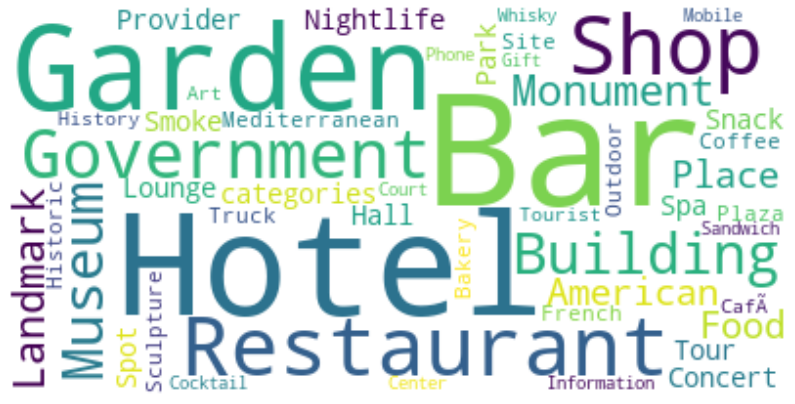

In [56]:
# display the word cloud
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height
plt.imshow(tour_wc, interpolation='bilinear')
plt.axis('off')
plt.show()


## Map Visualisation

In [57]:
#Let's visualize these items on the map around our location¶
venues_map = folium.Map(location=[latitude, longitude], zoom_start=15) # generate map centred around Ecco

#colors = [purple, orange, darkred,lightred,beige,darkblue, darkgreen, cadetblue, darkpurple, pink, lightblue, lightgreen,lightgray]
# categories
#

# folium.Marker([lat, lon], popup=str(name)+': '+color+'-'+str(clname), icon=folium.Icon(color=color)).add_to(feature_group)

# add Ecco as a red circle mark
label = folium.Popup('eiffel', parse_html=True)
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    popup=label,
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(venues_map)


# add popular spots to the map as blue circle markers
for lat, lng, name, category in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.name, dataframe_filtered.categories):
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    folium.features.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        fill=True,
        color= 'green',
        fill_color = 'black',
        fill_opacity=0.6
        ).add_to(venues_map)

# display map
venues_map

##  Step 10 - Tendance of this Venue

In [64]:
# tendances du quartier
# define URL
url = 'https://api.foursquare.com/v2/venues/trending?client_id={}&client_secret={}&ll={},{}&v={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION)

# send GET request and get trending venues
results = requests.get(url).json()
#results

In [65]:
if len(results['response']['venues']) == 0:
    trending_venues_df = 'No trending venues are available at the moment!'
    
else:
    trending_venues = results['response']['venues']
    trending_venues_df = json_normalize(trending_venues)

    # filter columns
    columns_filtered = ['name', 'categories'] + ['location.distance', 'location.city', 'location.postalCode', 'location.state', 'location.country', 'location.lat', 'location.lng']
    trending_venues_df = trending_venues_df.loc[:, columns_filtered]

    # filter the category for each row
    trending_venues_df['categories'] = trending_venues_df.apply(get_category_type, axis=1)

In [66]:
trending_venues_df

'No trending venues are available at the moment!'

## Map visualisation

In [61]:
if len(results['response']['venues']) == 0:
    venues_map = 'Cannot generate visual as no trending venues are available at the moment!'

else:
    venues_map = folium.Map(location=[latitude, longitude], zoom_start=15) # generate map centred around Ecco


    # add Ecco as a red circle mark
    label = folium.Popup('Arc de Triomphe', parse_html=True)
    folium.features.CircleMarker(
        [latitude, longitude],
        radius=15,
        popup=label,
        fill=True,
        color='red',
        fill_color='red',
        fill_opacity=0.6
    ).add_to(venues_map)


    # add the trending venues as blue circle markers
    for lat, lng, name, category in zip(trending_venues_df['location.lat'], trending_venues_df['location.lng'], trending_venues_df['name'], trending_venues_df['categories']):
        label = '{}, {}'.format(name, category)
        label = folium.Popup(label, parse_html=True)
        folium.features.CircleMarker(
            [lat, lng],
            radius=10,
            poup=label,
            fill=True,
            color='blue',
            fill_color='black',
            fill_opacity=0.6
        ).add_to(venues_map)

In [62]:
venues_map

'Cannot generate visual as no trending venues are available at the moment!'

###### As there is not enough data on trending venues of Washington DC on Foursquare API we can't Access this part of my analysis however, this code is attached for vice-versa situation

# Result :
### According to the analysis i predict that Lincoln memorial will be most feasible according to client to have a full use of time explore the locality 

### However, if there is time i suggest National Mall for exploration as this place has lots of hotel for stay and a word map is attaches for your benefit 



# Discussion And Conclusion :

### Here is the end of the data analysis. It is possible to rework some chart, but I think I already have enough result to make a conclusion.

### The example for this capital Washington DC can also be realized for the other three. It is also interesting that we can compare to each other. Other factors could be added such as weather and cost depending on the time of the year chosen.

### Thank you for following me in my analysis.